In [1]:
!pip install faiss-gpu

In [2]:
!pip install pandas-profiling

In [3]:
import faiss

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pandas_profiling import ProfileReport
import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-f3f9b3e7a84c>:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [4]:
df_base = pd.read_csv('/content/drive/MyDrive/data/base.csv', index_col=0)
df_train = pd.read_csv('/content/drive/MyDrive/data/train.csv', index_col=0)
df_valid = pd.read_csv('/content/drive/MyDrive/data/validation.csv', index_col=0)
df_valid_answ = pd.read_csv('/content/drive/MyDrive/data/validation_answer.csv', index_col=0)

In [5]:
df_base.rename_axis('id').head(2)

0          1         2          3           4          5  \
id                                                                          
0-base -115.083890  11.152912 -64.42676 -118.88089  216.482440 -104.69806   
1-base  -34.562202  13.332763 -69.78761 -166.53348   57.680607  -86.09837   

                 6          7           8          9  ...          62  \
id                                                    ...               
0-base -469.070588  44.348083  120.915344  181.44970  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.23419  ... -117.767525   

               63         64         65        66         67         68  \
id                                                                        
0-base  38.800827 -151.76218 -74.389090  63.66634  -4.703861   92.93361   
1-base  41.100000 -157.82940 -94.446806  68.20211  24.346846  179.93793   

               69          70         71  
id                                        
0-base  115.26919 -112.756640 -60.830353  
1-base  116.83400  -84.888941 -59.524610  

[2 rows x 72 columns]

In [6]:
df_train.rename(columns=str.lower, inplace=True)
df_train.rename_axis('id').head(2)

0          1          2          3          4         5  \
id                                                                         
0-query -53.882748  17.971436 -42.117104 -183.93668  187.51749 -87.14493   
1-query -87.776370   6.806268 -32.054546 -177.26039  120.80333 -83.81059   

                  6          7          8           9  ...         63  \
id                                                     ...              
0-query -347.360606  38.307602  109.08556   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.91590  140.331070  ...   4.669178   

                64          65         66         67         68         69  \
id                                                                           
0-query -155.80257 -101.965943  65.903790  34.457500  62.642094  134.76360   
1-query -151.69771   -1.638704  68.170876  25.096191  89.974976  130.58963   

                  70         71       target  
id                                            
0-query  -415.750254 -25.958572  675816-base  
1-query -1035.092211 -51.276833  366656-base  

[2 rows x 73 columns]

In [7]:
# Правильные ответы выделяем в отдельную сущность
targets = df_train['target']
df_train.drop('target', axis=1, inplace=True)

In [8]:
df_valid.rename_axis('id').head(2)

0          1          2          3          4  \
id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   

                      5           6           7           8          9  ...  \
id                                                                      ...   
100000-query -81.279594 -461.003172  139.815720  112.880980  75.215750  ...   
100001-query -90.520130 -759.626065   63.995087  127.117905  53.128998  ...   

                    62         63         64         65        66         67  \
id                                                                             
100000-query -75.51302  52.830902 -143.43945  59.051935  69.28224  61.927513   
100001-query -79.44183  29.185436 -168.60590 -82.872443  70.76560 -65.975950   

                     68          69           70         71  
id                                                           
100000-query  111.59253  115.140656 -1099.130485 -117.07936  
100001-query   97.07716  123.391640  -744.442332  -25.00932  

[2 rows x 72 columns]

In [9]:
df_valid_answ.rename(columns=str.lower, inplace=True)
df_valid_answ.rename_axis('id').head(2)

expected
id                        
100000-query  2676668-base
100001-query    91606-base

Построим профайл для df_train:

In [10]:
profile = ProfileReport(df_train, progress_bar=False, minimal=True)
profile

df_train:

В основном признаки имеют нормальное распределение, кроме:  
Признак 6: 20.8% значений = -759, 6.8% значений =-530.   
Признак 21: 64.1% значений = 1507.  
Признак 25: 83.3% значений = 813.   
Признак 33: можно назвать мультимодальным распределением.  
Признак 44: 7.3% значений = -61.  
Признаки 59, 65: равномерное распределение.  
Признак 70: 22.9% значений = -1074.  
  
  
Признаки лежат как в отрицательном диапазоне значений, так и в положительном.   

Посмотрим на диаграммы размаха предоставленных данных, еще раз проверим выбросы и аномалии в base и train:

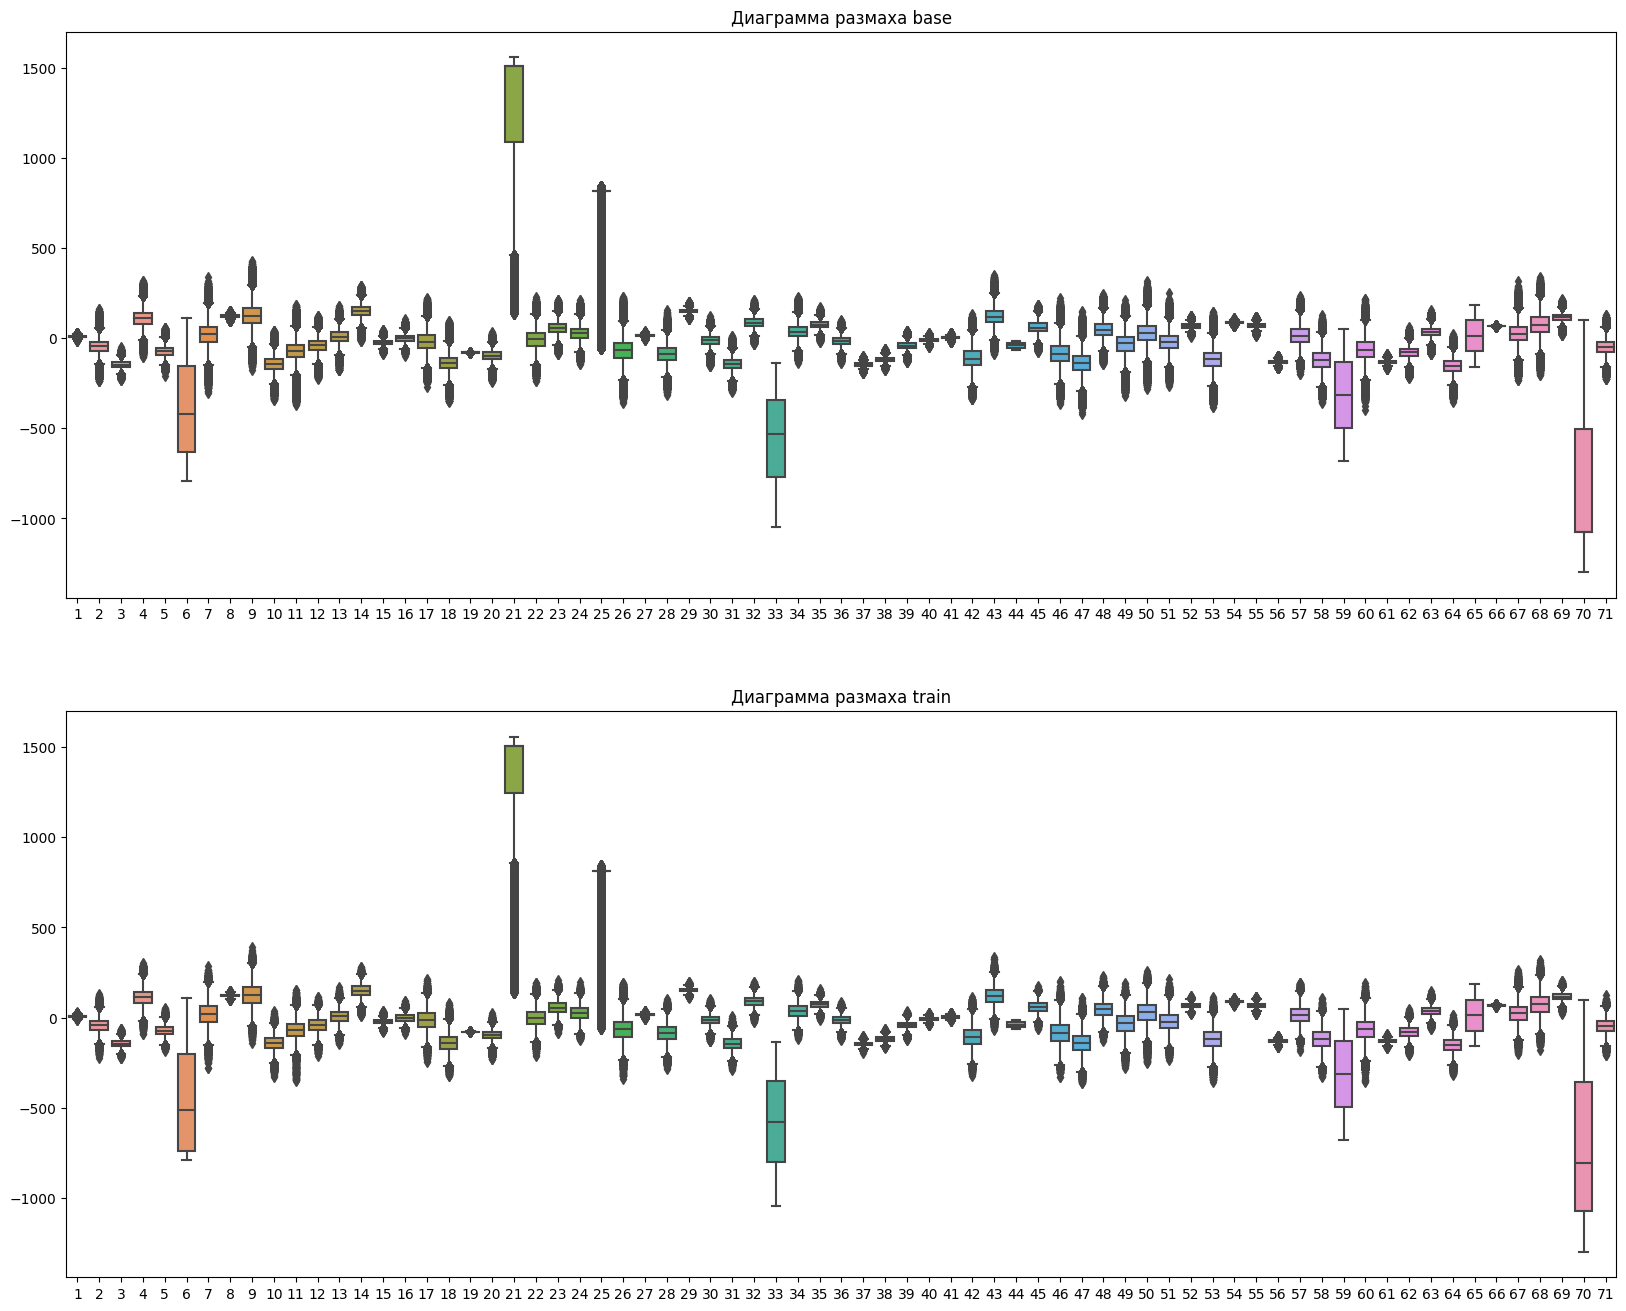

In [11]:
plt.figure(figsize=(20,25))
columns = df_base.columns[1:].tolist()
cnt = 1
for name, table in zip(['base', 'train'], [df_base, df_train]):
    plt.subplot(3, 1, cnt)
    cnt += 1
    sns.boxplot(data=table[columns])
    plt.title(f'Диаграмма размаха {name}')

Отдельно изучим признаки 6, 21, 25, 33, 59, 70.

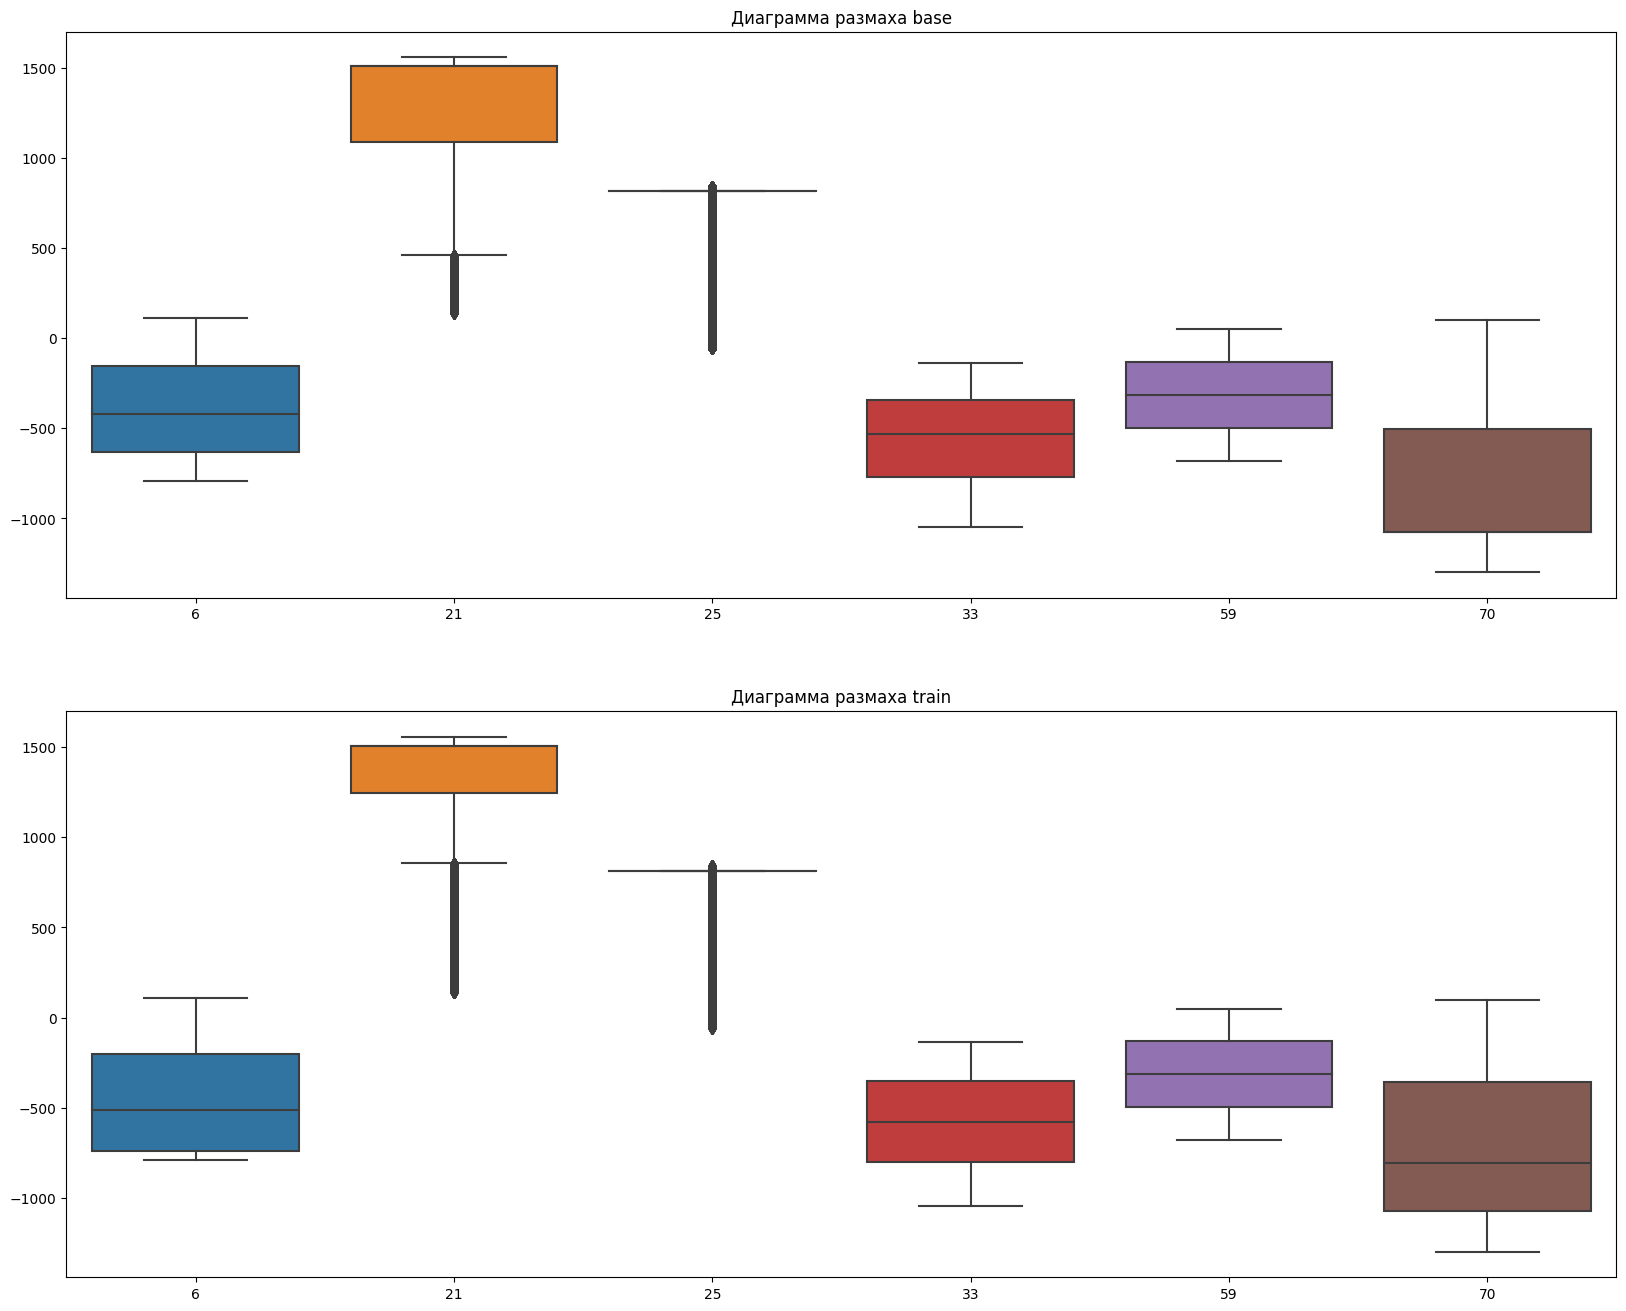

In [12]:
plt.figure(figsize=(20,25))
columns = df_base.columns[1:].tolist()
indices_to_show = [5, 20, 24, 32, 58, 69]

cnt = 1
for name, table in zip(['base', 'train'], [df_base, df_train]):
    plt.subplot(3, 1, cnt)
    cnt += 1
    sns.boxplot(data=table[columns].iloc[:, indices_to_show])
    plt.title(f'Диаграмма размаха {name}')

Попробуем создать дополнительные категориальные признаки, которые будут отображать относится значение признака к аномалиям или нет (не стали этого делать, т.к. новые категориальные признаки ухудшают метрику):

| № признака | Условие для категории = 1 | Условие для категории = 0 |
|------------|--------------------------|--------------------------|
| 6          | =-530.1247241 или =-759.6260648        | <>-530.1247241 и <>-759.6260648         |
| 21         | =1507.231274                    | <>1507.231274                  |
| 25         | =813.7700714                     | <>813.7700714                   |
| 70         | =-1074.464888                   | <>-1074.464888                 |

In [13]:
values = df_train['6'].value_counts().index[:5]
print(values)

Float64Index([ -759.626064846782, -530.1247240719107, 62.154667812093685,
              -463.1342393724077, -366.4737638981344],
             dtype='float64')


In [14]:
def add_categories_to_dataframes(dataframes):
    for df in dataframes:
        df['6_category'] = df['6'].apply(lambda x: 1 if np.isclose(x, -530.1247241) or np.isclose(x, -759.6260648) else 0)
        df['21_category'] = df['21'].apply(lambda x: 1 if np.isclose(x, 1507.231274) else 0)
        df['25_category'] = df['25'].apply(lambda x: 1 if np.isclose(x, 813.7700714) else 0)
        df['70_category'] = df['70'].apply(lambda x: 1 if np.isclose(x, -1074.464888) else 0)

Проверим попарную корреляцию признаков. Посмотрим только на те столбцы, где коэффициент корреляции >=0.9:

In [15]:
def plot_phik_overview(dataframe):
    phik_overview = dataframe.phik_matrix()

    mask = phik_overview >= 0.9
    filtered_phik = np.where(mask, phik_overview, 0)
    selected_columns = phik_overview.columns[mask.any(axis=0)]

    figure, axes = plt.subplots(figsize=(10, 10))
    axes.matshow(filtered_phik, cmap='Pastel1_r')

    axes.set_xticks(np.arange(len(selected_columns)))
    axes.set_xticklabels(selected_columns, rotation=90)

    axes.set_yticks(np.arange(len(selected_columns)))
    axes.set_yticklabels(selected_columns)

    plt.title(r'correlation $\phi_K$ (filtered, >= 0.9)', fontsize=14)
    plt.tight_layout()
    plt.show()

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']


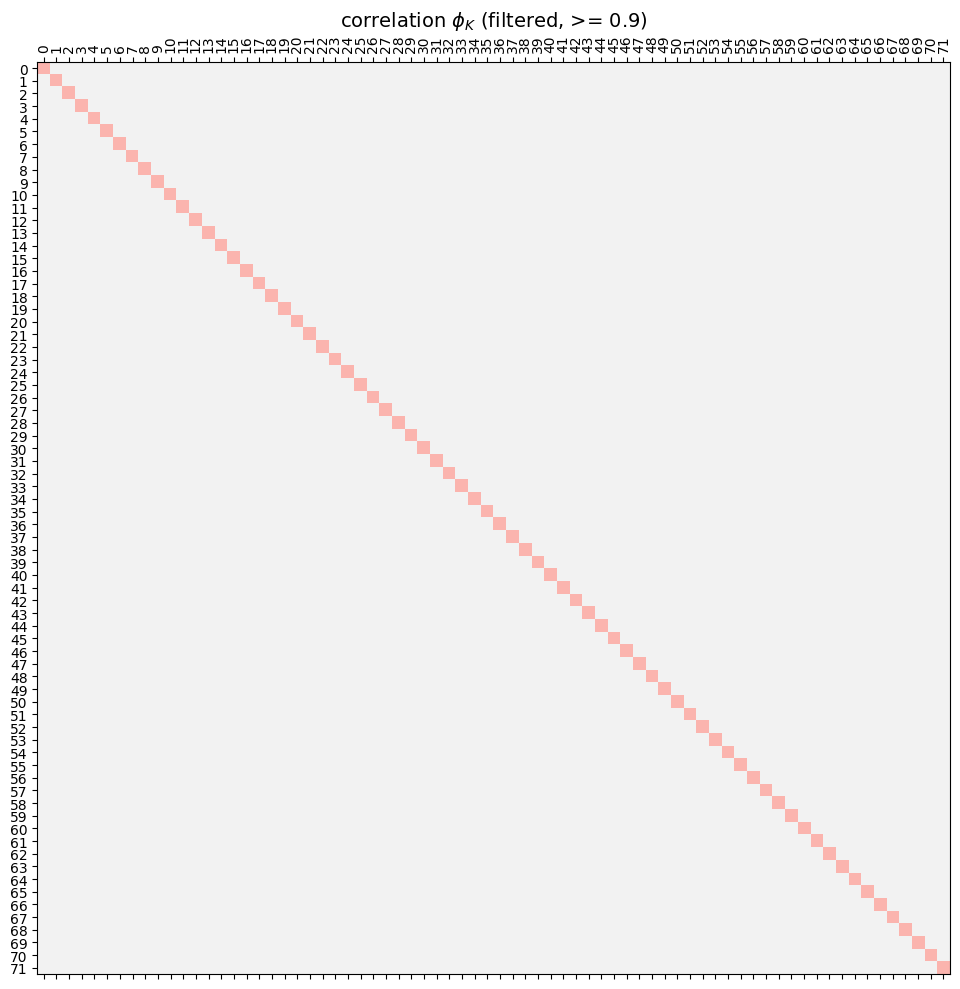

In [16]:
plot_phik_overview(df_train)

Результат ожидаемый. Попробуем удалить столбцы 6, 21, 25 и 70 во всех выборках (удалять их будем как в обучающей, так и в тестовой выборках, чтобы модель не искала на тесте взаимосвязь между ненужными признаками). До этого проверим наличие полных дубликатов по строкам:  
  
*Upd: удаление исходных признаков и добавление новых ухудшило метрику acc@5 до 50*  
*Upd 2: добавление новых фич без удаления чего-либо ухудшило метрику acc@5 до 46.276*  
*Upd 3: удаление исходных аномальных признаков 6, 21, 25 и 70 улучшило метрику acc@5 до 54.922*  
*Upd 4: удаление исходных аномальных признаков 6, 21, 25, 33, 59, 70 улучшило метрику acc@5 до 60.195, при этом появились дубликаты строк*

In [17]:
print(df_train.duplicated().sum())
print(df_base.duplicated().sum())
print(df_valid.duplicated().sum())

0
0
0


In [18]:
def drop_columns(dataframes):
    for df in dataframes:
        df.drop(columns=['6', '21', '25', '33', '59', '70'], inplace=True)

In [19]:
dataframes = [df_train, df_base, df_valid]
drop_columns(dataframes)

In [20]:
print(df_train.duplicated().sum())
print(df_base.duplicated().sum())
print(df_valid.duplicated().sum())

2916
353798
2888


Преобразуем dataframes в np.arrays:

In [21]:
base = df_base.values.astype('float32')
train = df_train.values.astype('float32')
valid = df_valid.values.astype('float32')

Перед обучением модели faiss применим нормализацию данных. Нормализация может помочь уменьшить влияние различных шкал и единиц измерения между признаками и сделать данные более сопоставимыми. Новые категориальные столбцы также нормализуем, т.к. это может помочь создать более сбалансированные веса для всех признаков, включая бинарные столбцы. Это может улучшить качество поиска и повысить точность метрики accuracy@5.

In [22]:
scaler = StandardScaler()
base_normalized = scaler.fit_transform(base)
train_normalized = scaler.transform(train)

In [23]:
dims = base_normalized.shape[1]
n_cells = 500 # меняем кол-во кластеров
# Сейчас будем бросать вектора размерностью dim 72 и их близость оценивать по Евклидовой норме.
quantizer = faiss.IndexFlatL2(dims)
# Чтобы ускорить процесс используем Inverted File Index, dims=72 измерения, n_cells - кол-во кластеров (групп векторов), их подкручиваем
# "pinecone faiss: the missing manual"
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [24]:
# Создание кластеров. Берем полученный индекс idx_l2 (как мы будем хранить данные, саму идею) и ее обучаем.
# Мы забрасываем в индекс несколько векторов. Их получаем из исходного base, берем первые 50000 векторов, функция np.ascontiguousarray делает так,
# чтобы весь массив векторов лежал в оперативной памяти подряд без пропусков. Приводим к float32. Запускаем train.
# В этот момент происходит создание кластеров ()
idx_l2.train(np.ascontiguousarray(base_normalized[:50000,:]).astype('float32'))


# Затем все имеющиеся вектора забрасываем в созданные кластеры. Таким образом инициализируем базу данных.
idx_l2.add(np.ascontiguousarray(base_normalized).astype('float32'))

# Теперь можно обращаться к БД и говорить "дай мне самые близкие вектора". Вектора лежат без названий, просто под номерами 1, 2, 3.

In [25]:
# Чтобы понимать, что это за вектора, берем названия (из индексов) и нумеруем их подряд.

base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

# del df_base - сделать

In [26]:
# Из всех векторов df_train находим по 5 ближайших соседей. vecs - векторы, idx - их индексы.
vecs, idx = idx_l2.search(np.ascontiguousarray(train_normalized).astype('float32'), 5)

In [27]:
# Вычисляем метрику accuracy@5
acc = 0

for target, el in zip(targets.values.tolist(), idx.tolist()):
  acc += int(target in [base_index[r] for r in el])

print(f'Accuracy@5 на train: {100* acc/len(idx)}')

Accuracy@5 на train: 60.195


Проверяем модель на тесте:

In [32]:
valid_normalized = scaler.transform(valid)
vecs_valid, idx_valid = idx_l2.search(np.ascontiguousarray(valid_normalized).astype('float32'), 5)

acc_valid = 0

for target, el in zip(df_valid_answ['expected'].values.tolist(), idx_valid.tolist()):
    acc_valid += int(target in [base_index[r] for r in el])

print(f'Accuracy@5 на valid: {100 * acc_valid / len(idx_valid)}')

Accuracy@5 на valid: 59.982


1. Создаем массивы base, train и valid, преобразуя данные из фреймов данных df_base, df_train и df_valid в формат float32.
2. Нормализуем данные для улучшения качества faiss
3. Определяем размерность (dims) массива base.
4. Создаем объект quantizer, используя faiss.IndexFlatL2, которая выполняет быстрый поиск по евклидовой метрике.
5. Создаем индекс idx_l2, используя faiss.IndexIVFFlat с параметрами quantizer, dims и n_cells. Этот индекс разбивает пространство на ячейки для оптимизации поиска.
6. Обучаем индекс idx_l2 на первых 50000 элементах массива base.
7. Создаем словарь base_index, сопоставляющий каждому индексу из массива df_base.index список значений из df_base.index.to_list().
8. Используем индекс idx_l2 для поиска 5 наиболее близких соседей для каждого элемента массива train. Возвращает массив векторов vecs и массив индексов соседей idx.
9. После цикла по всем элементам массива targets вычисляем итоговую точность (accuracy) путем деления счетчика точных совпадений (acc) на общее количество элементов в массиве train.
10. Общий результат работы кода - значение точности (accuracy) на train в интервале от 0 до 100.